# Lab 1b: Linear classification

The [Fashion-MNIST dataset](https://www.openml.org/d/40996) contains 70,000 images of Zalando fashion products, classified into 10 types of clothing, each represented by 28 by 28 pixel values. We's see how well we can classify these with linear models. Let's start with looking at our data:

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

# Hide convergence warning for now
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action="ignore", category=ConvergenceWarning)

In [2]:
# Download FMINST data. Takes a while the first time.
fmnist = oml.datasets.get_dataset(40996)
X, y, _, _ = fmnist.get_data(target=fmnist.default_target_attribute); 
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

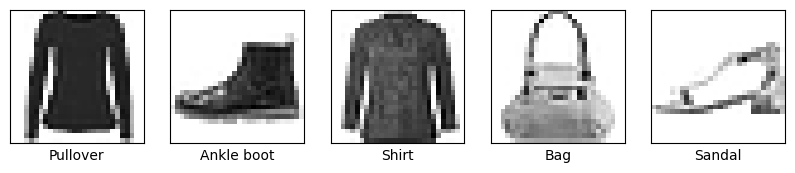

In [3]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X.values[n].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[i].set_xlabel((fmnist_classes[int(y.values[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

## Exercise 1: A quick benchmark
First, we'll try the default [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and [Linear SVMs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC). Click the links to read the documentation. We'll also compare it to [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) as a point of reference. To see whether our models are overfitting, we also evaluate the training set error. This can be done using [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) instead of  [`cross_val_scores`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score).

For now we are just interested in a quick approximation, so we don't use the full dataset for our experiments. Instead, we use 10% of our samples:

In [4]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Take a 10% stratified subsample to speed up experimentation
Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.1)

With this small sample of our data we can now train and evaluate the three classifiers.

### Exercise 1.1
Implement a function below which evaluates each classifier passed into it on the given data, and then returns both the train and test scores of each as a list. You are allowed to import additional functions from whichever module you like, but you should be able to complete the function with [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function and standard Python built-ins. Below the function you will find example output.

In [7]:
def evaluate_learners(classifiers, X, y):
    """ Evaluate each classifier in 'classifiers' with cross-validation on the provided (X, y) data. 
    
    Given a list of scikit-learn classifiers [Classifier1, Classifier2, ..., ClassifierN] return two lists:
     - a list with the scores obtained on the training samples for each classifier,
     - a list with the test scores obtained on the test samples for each classifier.
     The order of scores should match the order in which the classifiers were originally provided. E.g.:     
     [Classifier1 train score, ..., ClassifierN train score], [Classifier1 test score, ..., ClassifierN test score]
    """
    train_scores = []
    test_scores = []

    for model in classifiers:
        print(model)
        scores = cross_validate(model, X, y, cv=5, scoring="r2", return_train_score=True)
        train_scores.append(scores['train_score'])
        test_scores.append(scores['test_score'])
    
    return train_scores, test_scores
        

# # Example output:
# train_scores, test_scores = ([[0.92 , 0.924, 0.916, 0.917, 0.921],  # Classifier 1 train score for each of 5 folds.
#                               [0.963, 0.962, 0.953, 0.912, 0.934],  # Classifier 2 train score for each of 5 folds.
#                               [0.867, 0.868, 0.865, 0.866, 0.866]], # Classifier 3 train score for each of 5 folds.
#                              [[0.801, 0.811, 0.806, 0.826, 0.804],  # Classifier 1 test score for each of 5 folds.
#                               [0.766, 0.756, 0.773, 0.756, 0.741],  # Classifier 2 test score for each of 5 folds.
#                               [0.804, 0.814, 0.806, 0.821, 0.806]]) # Classifier 3 test score for each of 5 folds.

### Exercise 1.2
Call the function you created with a Logistic Regression, Linear SVM, and k-Nearest Neighbors Classifier.
Store the return values in the variables `train_scores` and `test_scores`. Then, run the code given below to produce a plot visualizing the scores.

In [8]:
classifiers = [LogisticRegression(), LinearSVC(), KNeighborsClassifier()]
train_scores, test_scores = evaluate_learners(classifiers, Xs, ys)

LogisticRegression()
LinearSVC()
KNeighborsClassifier()


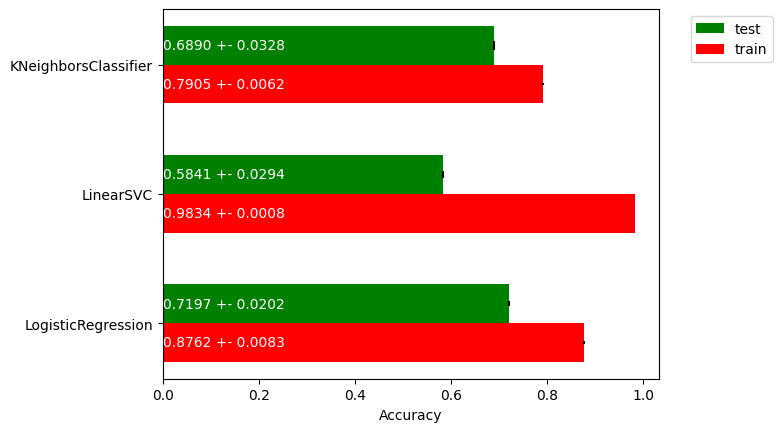

In [9]:
# Plot a bar chart of the train and test scores of all the classifiers, including the variance as error bars
fig, ax = plt.subplots()
width=0.3
ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
    ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
ax.set_xlabel('Accuracy')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

### Exercise 1.3
Interpret the plot. Which is the best classifier? Are any of the models overfitting? If so, what can we do to solve this? Is there a lot of variance in the results?

## Exercise 2: Regularization
We will now tune these algorithm's main regularization hyperparameter: the misclassification cost in SVMs (C), the regularization parameter in logistic regression (C), and the number of neighbors (n_neighbors) in kNN. We expect the optimum for the C parameters to lie in $[10^{-12},10^{12}]$ and for n_neighbors between 1 and 50. C should be varied on a log scale (i.e. [0.01, 0.1, 1, 10, 100]) and k should be varied uniformly (i.e. [1,2,3,4]).

In [10]:
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV

plt.figure(figsize=(15,5))
for i, model in tqdm(enumerate(classifiers), total=len(classifiers)):
    param_name = 'C' if i < 2 else 'n_neighbors'
    param_grid = {param_name: np.logspace(-12, 12, 5, base=10) if i < 2 else np.arange(1, 50, 10)}
    grid = GridSearchCV(model, param_grid, cv=5, return_train_score=True, scoring='r2')
    grid.fit(X, y)
    plt.subplot(1,3,i+1)
    plt.plot(param_grid[param_name], grid.cv_results_['mean_train_score'], label='train', marker='o')
    plt.plot(param_grid[param_name], grid.cv_results_['mean_test_score'], label='test', marker='o')
    plt.title(f"{model} - R^2 best: {float(grid.best_params_[param_name]):.2}")
    plt.xscale('log' if i < 2 else 'linear')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

C:\Users\toell\AppData\Local\Temp\ipykernel_19356\3049948026.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, model in tqdm(enumerate(classifiers), total=len(classifiers)):


  0%|          | 0/3 [00:00<?, ?it/s]

### Exercise 2.1
Vary the regularization parameters in the range given above and, for each classifier, create a line plot that plots both the training and test score for every value of the regularization hyperparameter. Hence, you should produce 3 plots, one for each classifier. Use the default 5-fold cross validation for all scores, but only plot the means.

Hints:
* Think about the time complexity of these models. Trying too many hyperparameter values may take too much time.
* You can make use of numpy's [logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [geomspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace), and [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace) functions.
* You can use matplotlib's default [plot](https://matplotlib.org/tutorials/introductory/pyplot.html) function to plot the train and test scores.
* You can manually loop over the hyperparameter ranges, or you can already check out scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to save some programming. We'll see it again later in the course.


#### Solution

In [8]:
# Generic plot for 1D grid search
# grid_search: the result of the GridSearchCV
# param_name: the name of the parameter that is being varied
def plot_tuning(grid_search, param_name, ax):
    ax.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_test_score'], marker = '.', label = 'Test score')
    ax.plot(grid_search.param_grid[param_name], grid_search.cv_results_['mean_train_score'], marker = '.', label = 'Train score')
    ax.set_ylabel('score (ACC)')
    ax.set_xlabel(param_name)
    ax.legend()
    ax.set_xscale('log')
    ax.set_title(grid_search.best_estimator_.__class__.__name__)
    bp, bs = grid_search.best_params_[param_name], grid_search.best_score_
    ax.text(bp,bs,"  C:{:.2E}, ACC:{:.4f}".format(bp,bs))

### Exercise 2.2
Interpret the plots. When are the methods underfitting? When are they overfitting? How sensitive are they to the regularization hyperparameter?

## Exercise 3: Interpreting misclassifications
Chances are that your models are not yet perfect. It is important to understand what kind of errors it still makes. Let's take a closer look at which instances are misclassified and which classes are often confused.
Train the logistic regression model with `C=1e-7`. Train the model on a training set, and make predictions for a test set (both sets should be  sampled from our 10% subsample).

In [9]:
# Create a stratified train-test split on a sample
X_train, X_test, y_train, y_test = train_test_split(Xs,ys, stratify=ys, random_state=0)

### Exercise 3.1
Train the classifier as described above, obtain the predictions `y_pred` on the test set, and identify all the misclassified samples `misclassified_samples`. Then, run the visualization code below to study the misclassifications

In [10]:
# Implement the code to obtain the actual predictions on the test set
y_pred = list(y_test) # dummy values, replace y_test with the actual predictions

# Implement the code to obtain the indices of the misclassified samples
# Example output:
# misclassified_samples = [  11,   12,   14,   23,   30,   34,   39,   46,   50,   52,   55]
misclassified_samples = [0,1,2,3,4] # dummy values

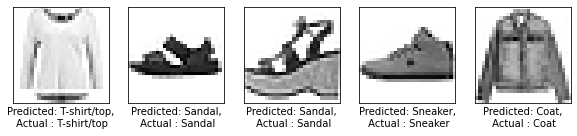

In [11]:
# Visualize the (first five) misclassifications, together with the predicted and actual class
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for nr, i in enumerate(misclassified_samples[:5]):
    axes[nr].imshow(X_test.values[i].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (fmnist_classes[int(y_pred[i])],fmnist_classes[int(y_test.values[i])]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())

plt.show();

### Exercise 3.2
Interpret the results. Are these misclassifications to be expected? 

### Exercise 3.3.
Run the code below on your results to draw the complete confusion matrix and get more insight on the systematic misclassifications 
of your model. A confusion matrix shows the amount of examples in for each pair of true and predicted classes. Interpret the results. 
Does your model produce certain types of error more often than other types? 

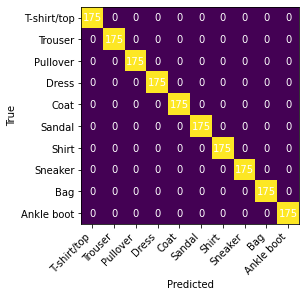

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(fmnist_classes.values()), rotation=45, ha="right")
ax.set_yticklabels(list(fmnist_classes.values()))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

## Exercise 4: Interpreting model parameters
Finally, we'll take a closer look at the model parameters, i.e. the coefficients of our linear models. Since we are dealing with 28x28 pixel images, we have to learn 784 coefficients. What do these coefficients mean? We'll start by plotting them as 28x28 pixel images.

### Exercise 4.1
Train a Logistic Regression model and a Linear SVM using their tuned hyperparameters from exercise 2. 
When in doubt, use `C=1e-7` for LogReg and `C=1e-8` for the SVM. 
Pass the trained model to the provided plotting function. Interpret the results in detail. 
Why do you get multiple plots per model? What do the features represent in your data. 
Does it seems like the models pay attention to the right features?
Do you models seem to ignore certain features? Do you observe differences in quality between the different classes? Do you observe any differences between the models?

In [13]:
# Plots the coefficients of the given model as 28x28 heatmaps. 
# The `name` attribute is optional, it is simply a title for the produced figure
def plot_coefficients(model, name=None):
    fig, axes = plt.subplots(1,10,figsize=(20,2))
    fig.suptitle(name if name else model.__class__.__name__)
    for i, ax in enumerate(axes):
        m = ax.imshow(model.coef_[i].reshape(28,28))
        ax.set_xlabel(fmnist_classes[i])
        ax.set_xticks(()), ax.set_yticks(())
    fig.colorbar(m, ax=axes.ravel().tolist())

### Exercise 4.2
Repeat the previous exercise, but now only with logistic regression. In addition to a tuned version, also add a model that overfits a lot and one that underfits a lot. Interpret and explain the results.